In [1]:
import pandas as pd
import glob
import os

Shapefile loaded successfully.
  CTLabel BoroCode   BoroName  CT2020 BoroCT2020 CDEligibil  \
0       1        1  Manhattan  000100    1000100       None   
1   14.01        1  Manhattan  001401    1001401       None   
2   14.02        1  Manhattan  001402    1001402       None   
3      18        1  Manhattan  001800    1001800       None   
4   22.01        1  Manhattan  002201    1002201       None   

                                             NTAName NTA2020 CDTA2020  \
0  The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1                                    Lower East Side  MN0302     MN03   
2                                    Lower East Side  MN0302     MN03   
3                                    Lower East Side  MN0302     MN03   
4                                    Lower East Side  MN0302     MN03   

                                            CDTANAME        GEOID  PUMA  \
0  MN01 Financial District-Tribeca (CD 1 Equivalent)  36061000100  4121   
1

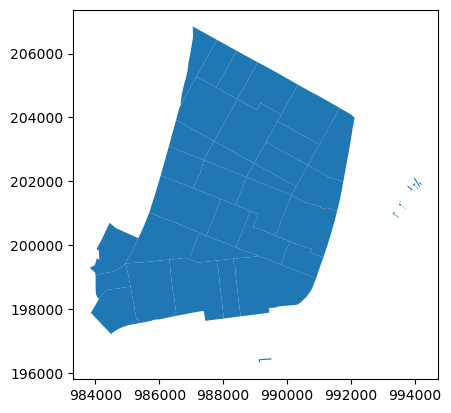

In [5]:
import geopandas as gpd

# Path to the shapefile (make sure all .shp, .shx, .dbf files are in the same folder)
shapefile_path = "/home/ymusic7/metro_restaurants/nyct2020.shp"

try:
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    print("Shapefile loaded successfully.")
    
    # Inspect the first few rows
    print(gdf.head())
    
    # Filter for Chinatown regions
    chinatown_gdf = gdf[
        gdf["NTAName"].str.contains("Chinatown", na=False, case=False) |
        gdf["CDTANAME"].str.contains("Chinatown", na=False, case=False)
    ]
    
    # Display the filtered GeoDataFrame
    print("Filtered GeoDataFrame (Chinatown regions):")
    print(chinatown_gdf)
    
    # Save the filtered GeoDataFrame to a new GeoJSON file
    output_geojson_path = "/home/ymusic7/metro_restaurants/chinatown_filtered.geojson"
    chinatown_gdf.to_file(output_geojson_path, driver="GeoJSON")
    print(f"Filtered GeoDataFrame saved to {output_geojson_path}.")
    
    # Optional: Visualize the filtered regions
    chinatown_gdf.plot()
    
except Exception as e:
    print(f"Error: {e}")


In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load Chinatown shapefile
chinatown_path = "/home/ymusic7/metro_restaurants/chinatown_filtered.geojson"
chinatown_gdf = gpd.read_file(chinatown_path)


reviews_path = "/home/ymusic7/metro_restaurants/ny_metro_all_restaurants.csv"  # Replace with your file
reviews_df = pd.read_csv(reviews_path)


if "lat" not in reviews_df.columns or "lon" not in reviews_df.columns:
    raise ValueError("The reviews dataset must contain 'lat' and 'lon' columns.")


reviews_gdf = gpd.GeoDataFrame(
    reviews_df,
    geometry=gpd.points_from_xy(reviews_df["lon"], reviews_df["lat"]),
    crs="EPSG:4326"  # Assuming WGS 84 projection
)

# Perform spatial join: reviews within Chinatown
chinatown_reviews = gpd.sjoin(reviews_gdf, chinatown_gdf, how="inner", predicate="intersects")

# non-Chinatown reviews
non_chinatown_reviews = reviews_gdf[~reviews_gdf.index.isin(chinatown_reviews.index)]

#save 
chinatown_reviews.to_file("/home/ymusic7/metro_restaurants/chinatown_reviews.geojson", driver="GeoJSON")
chinatown_reviews.drop(columns="geometry").to_csv("/home/ymusic7/metro_restaurants/chinatown_reviews.csv", index=False)

# Save Non-Chinatown reviews
non_chinatown_reviews.to_file("/home/ymusic7/metro_restaurants/non_chinatown_reviews.geojson", driver="GeoJSON")
non_chinatown_reviews.drop(columns="geometry").to_csv("/home/ymusic7/metro_restaurants/non_chinatown_reviews.csv", index=False)

print("Chinatown and non-Chinatown reviews have been saved.")



/scratch/local/jobs/26906247/ipykernel_3567892/1693421793.py:25: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:2263

  chinatown_reviews = gpd.sjoin(reviews_gdf, chinatown_gdf, how="inner", predicate="intersects")


Chinatown and non-Chinatown reviews have been saved.


In [12]:
import geopandas as gpd
from shapely.geometry import box

# NYC Bounding Box in EPSG:2263 (projected coordinates)
west_proj, south_proj, east_proj, north_proj = 913175.1090087891, 120128.36999511719, 1067382.508605957, 272844.2938232422

# Create a GeoDataFrame with the bounding box in EPSG:2263
bbox_proj = gpd.GeoDataFrame(
    {'geometry': [box(west_proj, south_proj, east_proj, north_proj)]},
    crs='EPSG:2263'
)

# Reproject to EPSG:4326 (WGS84)
bbox_wgs84 = bbox_proj.to_crs(epsg=4326)

# Extract the bounds in latitude/longitude
west_lon, south_lat, east_lon, north_lat = bbox_wgs84.total_bounds
print(f"Bounding Box in WGS84 (Longitude/Latitude):")
print(f"West Longitude: {west_lon}, South Latitude: {south_lat}")
print(f"East Longitude: {east_lon}, North Latitude: {north_lat}")


Bounding Box in WGS84 (Longitude/Latitude):
West Longitude: -74.25715897480136, South Latitude: 40.4960100162347
East Longitude: -73.69921518299194, North Latitude: 40.91528124638122


In [3]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Paths to your data
shapefile_path = "/home/ymusic7/metro_restaurants/Manhattan_Chinatown.shp"
restaurant_data_path = "/home/ymusic7/metro_restaurants/ny_metro_all_restaurants.csv"



In [5]:
import pandas as pd

# Load the four city CSVs
cities = [
    "ny_metro_all_restaurants.csv",
    "la_metro_all_restaurants.csv",
    "chicago_metro_all_restaurant.csv",
    "dallas_metro_all_restaurants.csv"
]
combined_df = pd.concat([pd.read_csv(city) for city in cities])

# Define Chinatown bounding boxes
chinatown_bounds = {
    "New York": {
        "lat_min": 40.713, "lat_max": 40.719,
        "lon_min": -74.006, "lon_max": -73.998
    },
    "Los Angeles": {
        "lat_min": 34.060, "lat_max": 34.065,
        "lon_min": -118.242, "lon_max": -118.233
    },
    "Chicago": {
        "lat_min": 41.844, "lat_max": 41.856,
        "lon_min": -87.638, "lon_max": -87.627
    },
    "San Francisco": {
        "lat_min": 37.793, "lat_max": 37.799,
        "lon_min": -122.410, "lon_max": -122.403
    }
}


# Add a column to identify Chinatown
def is_chinatown(row):
    for city, bounds in chinatown_bounds.items():
        if (bounds["lat_min"] <= row["lat"] <= bounds["lat_max"]) and \
           (bounds["lon_min"] <= row["lon"] <= bounds["lon_max"]):
            return city
    return None

combined_df["Chinatown"] = combined_df.apply(is_chinatown, axis=1)

# Filter for Chinatown and Non-Chinatown
chinatown_df = combined_df[combined_df["Chinatown"].notnull()]
non_chinatown_df = combined_df[combined_df["Chinatown"].isnull()]

# Save results
chinatown_df.to_csv("chinatown_restaurants.csv", index=False)
non_chinatown_df.to_csv("non_chinatown_restaurants.csv", index=False)



In [4]:
# Count the number of reviews in Chinatown and non-Chinatown DataFrames
chinatown_count = len(chinatown_df)
non_chinatown_count = len(non_chinatown_df)

print(f"Number of reviews in Chinatown restaurants: {chinatown_count}")
print(f"Number of reviews in non-Chinatown restaurants: {non_chinatown_count}")


Number of reviews in Chinatown restaurants: 0
Number of reviews in non-Chinatown restaurants: 217581


In [18]:
# Check the columns in the reviews DataFrame
print(reviews_df.columns)


Index(['name', 'lat', 'lon', 'text', 'date', 'score', 'keyword', 'addr',
       'language'],
      dtype='object')


In [ ]:
#chicago shapefile

In [20]:
import pandas as pd
import geopandas as gpd

# Load the shapefile
shapefile_path = '/home/ymusic7/metro_restaurants/Neighborhoods_2012b.shp'
gdf = gpd.read_file(shapefile_path)

# Filter Chinatown data (already done in previous step)
chinatown_neighborhoods = gdf[gdf['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False) | 
                              gdf['SEC_NEIGH'].str.contains('Chinatown', case=False, na=False)]

# Load Chicago reviews (replace this with the actual path to your review data)
reviews_path = '/home/ymusic7/metro_restaurants/chicago_metro_all_restaurant.csv'
reviews_df = pd.read_csv(reviews_path)

# Convert review DataFrame to GeoDataFrame using 'lat' and 'lon'
reviews_gdf = gpd.GeoDataFrame(reviews_df, 
                               geometry=gpd.points_from_xy(reviews_df['lon'], reviews_df['lat']))

# Set the same coordinate reference system (CRS) as the shapefile (assuming the shapefile uses EPSG:4326)
reviews_gdf = reviews_gdf.set_crs('EPSG:4326')

# Spatial join to match reviews with neighborhood polygons using the 'within' predicate
reviews_with_neighborhoods = gpd.sjoin(reviews_gdf, gdf, how='left', predicate='within')

# Filter Chinatown and Non-Chinatown reviews based on the neighborhood
chinatown_reviews = reviews_with_neighborhoods[reviews_with_neighborhoods['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False)]
non_chinatown_reviews = reviews_with_neighborhoods[~reviews_with_neighborhoods['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False)]

# Display some examples
print("Chinatown reviews:")
print(chinatown_reviews.head())

print("Non-Chinatown reviews:")
print(non_chinatown_reviews.head())


Chinatown reviews:
Empty GeoDataFrame
Columns: [name, lat, lon, text, date, score, keyword, addr, language, geometry, index_right, PRI_NEIGH, SEC_NEIGH, SHAPE_AREA, SHAPE_LEN]
Index: []
Non-Chinatown reviews:
                                       name        lat        lon  \
0                      New China Restaurant  42.557519 -87.836650   
1  China House Chinese Restaurant (Kenosha)  42.565608 -87.859814   
2                       Hong Kong Chop Suey  42.268801 -88.004368   
3                      New China Restaurant  42.121587 -88.258360   
4                      New China Restaurant  42.121587 -88.258360   

                                                text                 date  \
0  This restaurant has the best food in town!! Wo...  2024-07-05 18:37:09   
1  Been going here for years. Was a busy night an...  2024-10-16 01:00:06   
2  This restaurant is take-out only. The girls wo...  2024-10-18 22:00:12   
3                       味道不好，非常不卫生，吃过一次就知道永远不去这间歺馆吃。  2018-01-22 06:

/scratch/local/jobs/26906247/ipykernel_3567892/2785433463.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3435

  reviews_with_neighborhoods = gpd.sjoin(reviews_gdf, gdf, how='left', predicate='within')


In [21]:
import pandas as pd
import geopandas as gpd

# Load the shapefile
shapefile_path = '/home/ymusic7/metro_restaurants/Neighborhoods_2012b.shp'
gdf = gpd.read_file(shapefile_path)

# Load Chicago reviews
reviews_path = '/home/ymusic7/metro_restaurants/chicago_metro_all_restaurant.csv'
reviews_df = pd.read_csv(reviews_path)

# Convert review DataFrame to GeoDataFrame using 'lat' and 'lon'
reviews_gdf = gpd.GeoDataFrame(reviews_df, 
                               geometry=gpd.points_from_xy(reviews_df['lon'], reviews_df['lat']))

# Set the CRS of the review data to match the CRS of the shapefile (EPSG:3435)
reviews_gdf = reviews_gdf.set_crs('EPSG:4326')  # This sets the initial CRS of the reviews data
reviews_gdf = reviews_gdf.to_crs('EPSG:3435')  # Reproject to match the shapefile's CRS

# Spatial join to match reviews with neighborhood polygons using the 'within' predicate
reviews_with_neighborhoods = gpd.sjoin(reviews_gdf, gdf, how='left', predicate='within')

# Filter Chinatown and Non-Chinatown reviews based on the neighborhood
chinatown_reviews = reviews_with_neighborhoods[reviews_with_neighborhoods['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False)]
non_chinatown_reviews = reviews_with_neighborhoods[~reviews_with_neighborhoods['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False)]

# Display some examples
print("Chinatown reviews:")
print(chinatown_reviews.head())

print("Non-Chinatown reviews:")
print(non_chinatown_reviews.head())


Chinatown reviews:
Empty GeoDataFrame
Columns: [name, lat, lon, text, date, score, keyword, addr, language, geometry, index_right, PRI_NEIGH, SEC_NEIGH, SHAPE_AREA, SHAPE_LEN]
Index: []
Non-Chinatown reviews:
                                       name        lat        lon  \
0                      New China Restaurant  42.557519 -87.836650   
1  China House Chinese Restaurant (Kenosha)  42.565608 -87.859814   
2                       Hong Kong Chop Suey  42.268801 -88.004368   
3                      New China Restaurant  42.121587 -88.258360   
4                      New China Restaurant  42.121587 -88.258360   

                                                text                 date  \
0  This restaurant has the best food in town!! Wo...  2024-07-05 18:37:09   
1  Been going here for years. Was a busy night an...  2024-10-16 01:00:06   
2  This restaurant is take-out only. The girls wo...  2024-10-18 22:00:12   
3                       味道不好，非常不卫生，吃过一次就知道永远不去这间歺馆吃。  2018-01-22 06:

In [22]:
import pandas as pd
import geopandas as gpd

# Load the shapefile
shapefile_path = '/home/ymusic7/metro_restaurants/Neighborhoods_2012b.shp'
gdf = gpd.read_file(shapefile_path)

# Filter Chinatown data (already done in previous step)
chinatown_neighborhoods = gdf[gdf['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False) | 
                              gdf['SEC_NEIGH'].str.contains('Chinatown', case=False, na=False)]

# Load Chicago reviews (replace this with the actual path to your review data)
reviews_path = '/home/ymusic7/metro_restaurants/chicago_metro_all_restaurant.csv'
reviews_df = pd.read_csv(reviews_path)

# Convert review DataFrame to GeoDataFrame using 'lat' and 'lon'
reviews_gdf = gpd.GeoDataFrame(reviews_df, 
                               geometry=gpd.points_from_xy(reviews_df['lon'], reviews_df['lat']))

# Set the CRS of reviews_gdf to match gdf (EPSG:3435)
reviews_gdf = reviews_gdf.set_crs('EPSG:4326')  # Ensure the original CRS is set
reviews_gdf = reviews_gdf.to_crs(gdf.crs)  # Reproject to the same CRS as the shapefile

# Spatial join to match reviews with neighborhood polygons using the 'within' predicate
reviews_with_neighborhoods = gpd.sjoin(reviews_gdf, gdf, how='left', predicate='within')

# Filter Chinatown and Non-Chinatown reviews based on the neighborhood
chinatown_reviews = reviews_with_neighborhoods[reviews_with_neighborhoods['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False)]
non_chinatown_reviews = reviews_with_neighborhoods[~reviews_with_neighborhoods['PRI_NEIGH'].str.contains('Chinatown', case=False, na=False)]

# Count the number of Chinatown and Non-Chinatown reviews
chinatown_count = chinatown_reviews.shape[0]
non_chinatown_count = non_chinatown_reviews.shape[0]

# Display the counts
print(f"Number of Chinatown reviews: {chinatown_count}")
print(f"Number of Non-Chinatown reviews: {non_chinatown_count}")


Number of Chinatown reviews: 0
Number of Non-Chinatown reviews: 46751


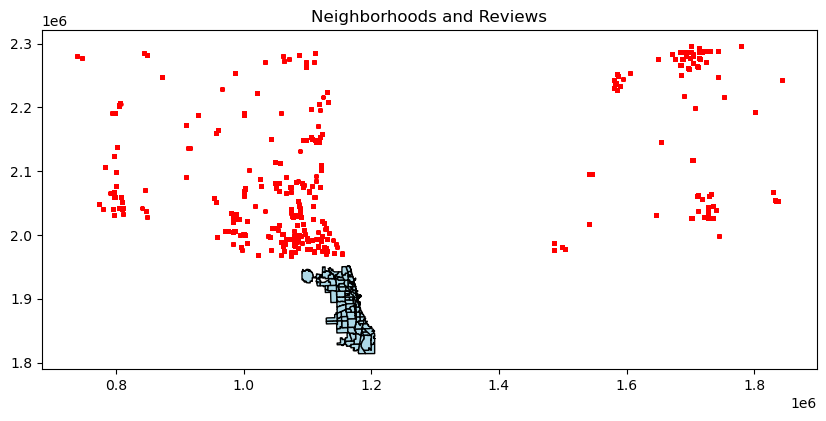

In [23]:
import matplotlib.pyplot as plt

# Plot the neighborhoods' geometry
ax = gdf.plot(figsize=(10, 10), color='lightblue', edgecolor='black')

# Plot the reviews (assuming 'geometry' is a valid column for review points)
reviews_gdf.plot(ax=ax, color='red', markersize=5)

plt.title("Neighborhoods and Reviews")
plt.show()


In [25]:
import geopandas as gpd

# Load the shapefile
shapefile_path = '/home/ymusic7/metro_restaurants/Neighborhoods_2012b.shp'
gdf = gpd.read_file(shapefile_path)

# Compute the centroid of the entire city of Chicago (you may want to use the whole dataset)
city_centroid = gdf.geometry.unary_union.centroid

# Get the longitude and latitude of the centroid
city_longitude = city_centroid.x
city_latitude = city_centroid.y

# Print the coordinates
print(f"City of Chicago Approximate Coordinates: Longitude = {city_longitude}, Latitude = {city_latitude}")


City of Chicago Approximate Coordinates: Longitude = 1160711.1061047243, Latitude = 1883895.4700881639


/scratch/local/jobs/26906247/ipykernel_3567892/2041039971.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_centroid = gdf.geometry.unary_union.centroid
